In [1]:
import pandas as pd
activities_df = pd.read_csv('data/activities.csv')

# Count the number of activities for each Activity Type
activity_counts = activities_df['Activity Type'].value_counts()
activity_counts

Run                1553
Ride                487
Swim                223
Virtual Ride         46
Weight Training      31
Workout               8
Walk                  3
Name: Activity Type, dtype: int64

In [2]:
# Look at how many rides have recorded Average Watts and Average Heart Rate

ride_activities = activities_df[activities_df['Activity Type'] == 'Ride']

# Convert 'Distance' to a numeric value for comparison
ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')

# Filter for rides over 10 distance units and with recorded Average Watts and Average Heart Rate
filtered_rides = ride_activities[(ride_activities['Distance'] > 10) & 
                                 (ride_activities['Average Watts'].notna()) & 
                                 (ride_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_ride_count = len(filtered_rides)
filtered_ride_count

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_76598/950879621.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')


237

In [5]:
# Look at how many rides have recorded Weighted Average Watts and Average Heart Rate

ride_activities = activities_df[activities_df['Activity Type'] == 'Ride']

# Convert 'Distance' to a numeric value for comparison
ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')

# Filter for rides over 10 distance units and with recorded Average Watts and Average Heart Rate
filtered_rides = ride_activities[(ride_activities['Distance'] > 10) & 
                                 (ride_activities['Weighted Average Power'].notna()) & 
                                 (ride_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_ride_count = len(filtered_rides)
filtered_ride_count

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_76598/2948070073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')


181

In [6]:
# Look at how many runs have recorded Average Watts and Average Heart Rate

# Filter for 'Run' activities
run_activities = activities_df[activities_df['Activity Type'] == 'Run']

# Filter for runs with recorded Average Watts and Average Heart Rate
filtered_runs = run_activities[(run_activities['Weighted Average Power'].notna()) & 
                               (run_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_run_count = len(filtered_runs)
filtered_run_count


167

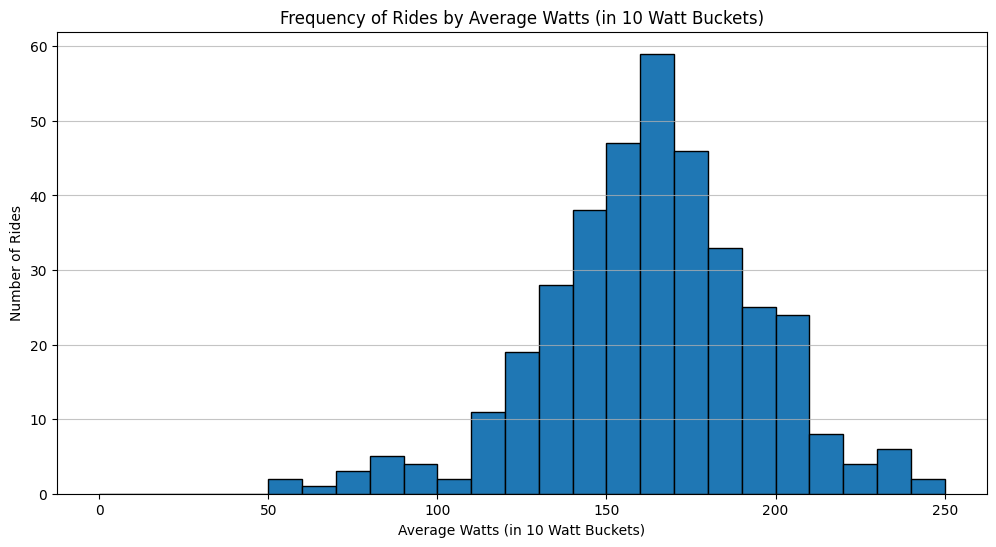

In [7]:
# View the power ranges in the summary file

import matplotlib.pyplot as plt
import numpy as np

# Dropping NaN values from 'Average Watts' for plotting
ride_watts = ride_activities['Weighted Average Power'].dropna()

# Creating a histogram
plt.figure(figsize=(12, 6))
plt.hist(ride_watts, bins=np.arange(0, ride_watts.max() + 10, 10), edgecolor='black')
plt.title('Frequency of Rides by Average Watts (in 10 Watt Buckets)')
plt.xlabel('Average Watts (in 10 Watt Buckets)')
plt.ylabel('Number of Rides')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [ ]:
import csv
import gzip
from fitparse import FitFile

def fit_gz_to_csv(fit_gz_file_path, csv_file_path):
    # Decompress the .fit.gz file and parse it
    with gzip.open(fit_gz_file_path, 'rb') as f:
        fitfile = FitFile(f)

        # Open or create the CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            headers_written = False

            # Iterate over all messages of type 'record'
            # (other types include 'device_info', 'activity', etc)
            for record in fitfile.get_messages('record'):

                # Get all data values from the record
                data = record.get_values()

                # Write the headers once
                if not headers_written:
                    writer.writerow(data.keys())
                    headers_written = True

                # Write the data values
                writer.writerow(data.values())

# Example usage
fit_gz_to_csv('path/to/input.fit.gz', 'path/to/output.csv')
